# Imports

In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from IPython.display import display

# Obtenção dos dados

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Algoritmo

In [3]:
def train_model(X_scaled, Y_scaled):
    max_lv = 10
    lvs = []
    k=1
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pca = PCA(n_components=lv)
        X_pca = pca.fit_transform(X_scaled)
        lin_reg = LinearRegression()

        # Calibração do modelo
        lin_reg.fit(X_pca, Y_scaled)
        predictions_train = lin_reg.predict(X_pca)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(lin_reg, X_pca, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
               
    for j in range(1, max_lv):
        if j + 1 <= max_lv:
            rmsecv_j = validation.loc[j + 1, 'rpearson_cv']
            rmsecv_j_plus_1 = validation.loc[j, 'rpearson_cv']
            aux = rmsecv_j / rmsecv_j_plus_1
            
            if aux > 1 and ((aux - 1) * 100 >= 2):
                lvs.append(j + 1)
                k += 1
    
    if len(lvs) == 0:
        lvs.append(1)
    
    lv_num = lvs[-1]
    
    if len(lvs) > 1:
        pca = PCA(n_components=lvs[-2])
        X_pca = pca.fit_transform(X_scaled)
        lin_reg = LinearRegression()
        lin_reg.fit(X_pca, Y_scaled)

        for w in range(k - 2):
            if lin_reg.coef_.shape[0] > 3:
                if lvs[w + 1] < lin_reg.coef_.shape[0] and lin_reg.coef_[lvs[w + 1], 3] < 1:
                    lv_num = lvs[w]
                    break

        model = lin_reg.fit(X_pca, Y_scaled)
    else:
        pca = PCA(n_components=lvs[0])
        X_pca = pca.fit_transform(X_scaled)
        lin_reg = LinearRegression()
        model = lin_reg.fit(X_pca, Y_scaled)

    return calibration, validation, lv_num, model, pca, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, pca, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,6:].values, y_pred.values)
    X_pred_pca = pca.transform(X_centered)  # Transformar dados de teste com PCA
    
    pred = model.predict(X_pred_pca)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation'])
    
    prediction = pd.DataFrame(columns=['r2_p', 'neg_root_mean_squared_error_p', 'explained_variance_p', 'correlation_p', 'rpearson_p', 'bias_p', 'sec_p'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
    
    
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    metrics_dict = pd.DataFrame({
    'Y': ['Referência', 'Predição'],
    'Slope': [slope_opt,slope_pred],
    'Offset': [offset_opt, offset_pred],
    'RMSE': [rmse_opt, rmse_pred],
    'R²': [r2_opt, r2_pred]
    })
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()
    
    return metrics_dict

def pred_plot(Y_predict):
    plt.figure(figsize=(15, 5))
    plt.title("Predicted with Deviation")

    # Plotar cada amostra
    for sample in Y_predict.index:
        y_pred = Y_predict.loc[sample, 'Y_pred']
        deviation = Y_predict.loc[sample, 'Deviation']
        y_true = Y_predict.loc[sample, 'Y_true']
        
        # Criar os dados do boxplot para esta amostra
        data_boxplot = [y_pred - deviation, y_pred, y_pred + deviation]
        
        # Plotar o boxplot
        plt.boxplot(data_boxplot, positions=[Y_predict.index.get_loc(sample)], widths=0.6, patch_artist=True, 
                    boxprops=dict(edgecolor='blue', linewidth=1.5),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
        
    plt.xticks(ticks=range(len(Y_predict.index)), labels=Y_predict['Amostra'], rotation=90)
    plt.xlabel('Samples')
    plt.ylabel('Predicted Y')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def build_model(X_cal, Y_cal, X_val, Y_val):
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    calibration, validation, lv_num, model, pca, Y_values = train_model(X.iloc[:,6:].values, Y.values)
    print(f'Número de componentes: {lv_num}')
        
    prediction, Y_predict = predict(model, pca, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_infos = plot_pred_vs_ref(Y_true, Y_pred, Y_opt)
    chart_data = pd.DataFrame({
    'Sample': Y_values.index,  # Identificador da amostra, pode ser index ou outra coluna específica
    'Y_true': Y_true,
    'Y_opt': Y_opt,
    'Y_pred': Y_pred
    })  
    display(chart_data)
    pred_plot(Y_predict)
    display(Y_predict)
    
    
    
    return calibration, validation, Y_predict, plot_infos


# Saída das predições

In [4]:
plot_infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'Slope', 'Offset', 'RMSE', 'R²'])
plot_infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'Slope', 'Offset', 'RMSE', 'R²'])
plot_infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'Slope', 'Offset', 'RMSE', 'R²'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


# MSC - PCR

Número de componentes: 10


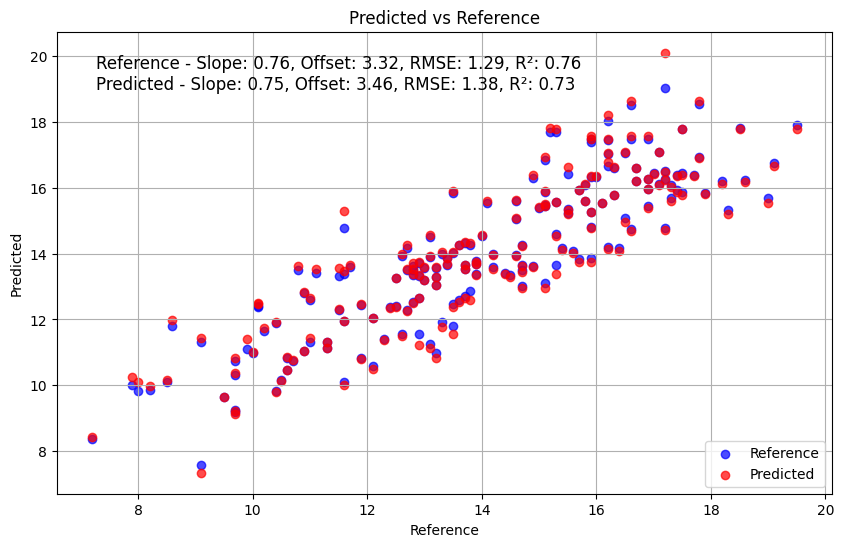

,Sample,Y_true,Y_opt,Y_pred
0,0,11.6,10.102221,10.019792
1,1,11.3,11.320561,11.321999
2,2,11.3,11.139278,11.133372
3,3,12.7,12.284155,12.269338
4,4,12.8,12.515751,12.507242
...,...,...,...,...
170,170,15.2,17.708876,17.826451
171,171,17.2,16.278187,16.238451
172,172,15.9,17.394005,17.491652
173,173,16.6,17.496623,17.566301


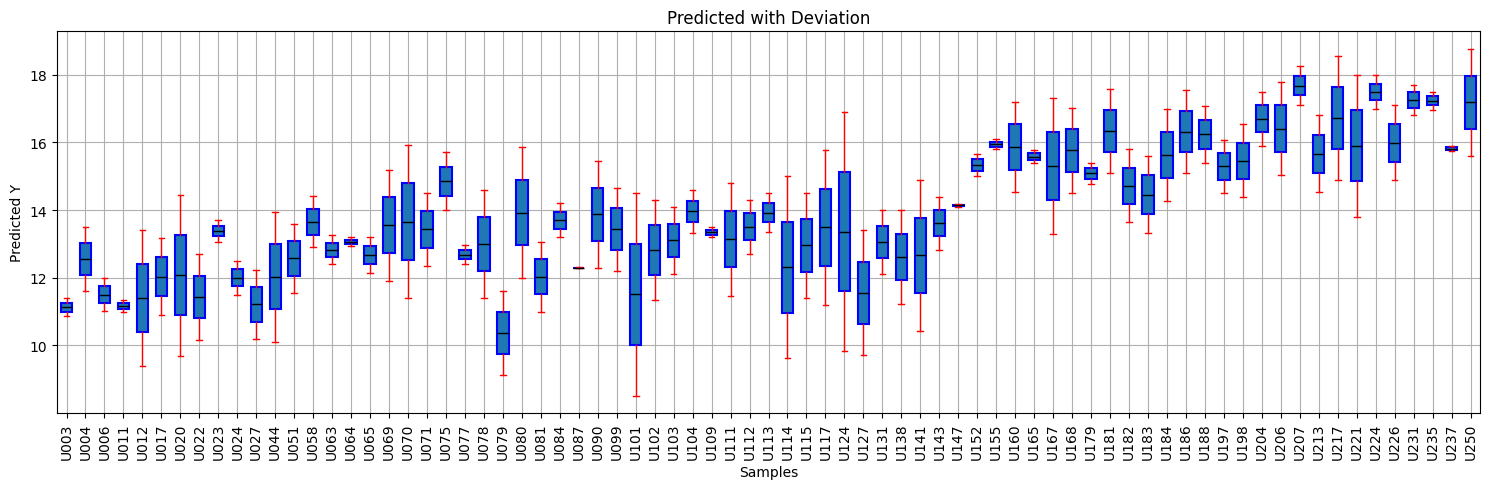

,Amostra,Y_pred,Y_true,Deviation
0,U003,11.134312,11.4,-0.265688
1,U004,12.545571,11.6,0.945571
2,U006,11.502186,12.0,-0.497814
3,U011,11.176998,11.0,0.176998
4,U012,11.406761,9.4,2.006761
...,...,...,...,...
70,U226,15.989184,17.1,-1.110816
71,U231,17.252091,16.8,0.452091
72,U235,17.231410,17.5,-0.268590
73,U237,15.819392,15.9,-0.080608


In [5]:
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst, plot_infos = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'SST')

Número de componentes: 8


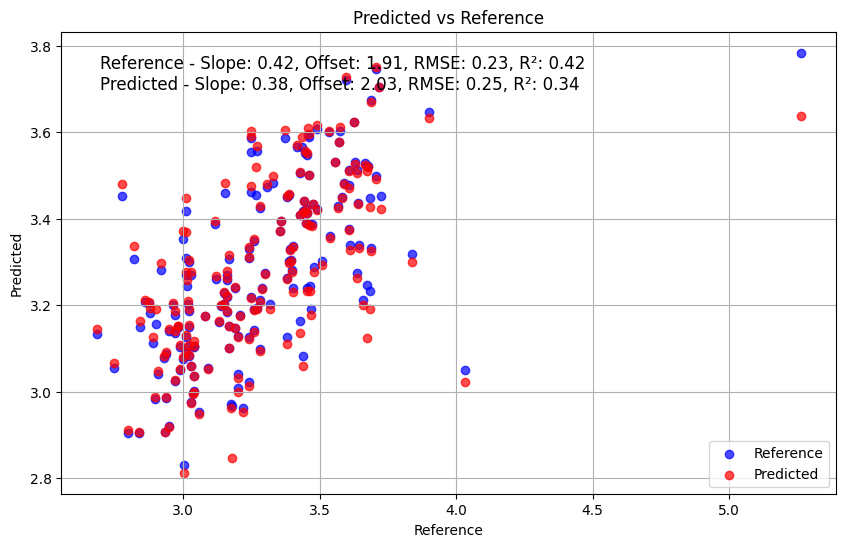

,Sample,Y_true,Y_opt,Y_pred
0,0,3.270,3.557394,3.567572
1,1,3.490,3.422214,3.420321
2,2,3.570,3.577554,3.577820
3,3,3.607,3.512133,3.509248
4,4,3.643,3.338247,3.332734
...,...,...,...,...
170,170,3.130,3.161771,3.162932
171,171,3.190,3.147570,3.146028
172,172,3.200,3.041417,3.031787
173,173,3.210,3.176852,3.174826


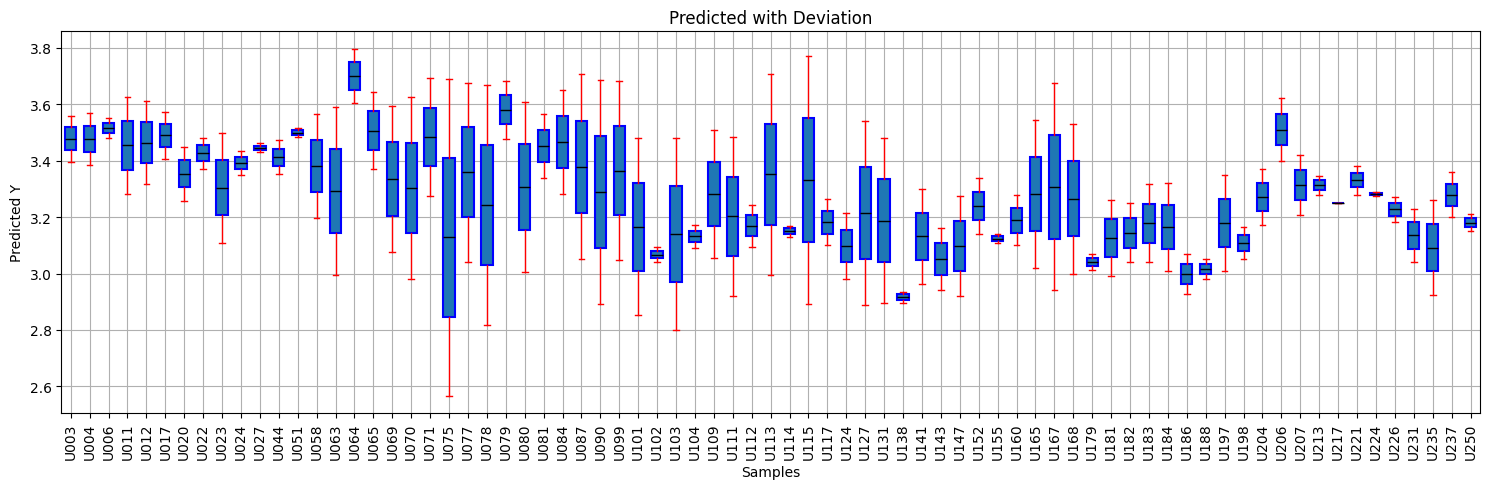

,Amostra,Y_pred,Y_true,Deviation
0,U003,3.478453,3.560,-0.081547
1,U004,3.477280,3.570,-0.092720
2,U006,3.515295,3.550,-0.034705
3,U011,3.454555,3.282,0.172555
4,U012,3.464381,3.318,0.146381
...,...,...,...,...
70,U226,3.227077,3.270,-0.042923
71,U231,3.135182,3.230,-0.094818
72,U235,3.091733,3.260,-0.168267
73,U237,3.279458,3.200,0.079458


In [6]:
calibration_msc_ph, validation_msc_ph, Y_predict_msc_ph, plot_infos = build_model(df_msc_cal, df_msc_cal['PH'], df_msc_val, df_msc_val['PH'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'PH')

Número de componentes: 4


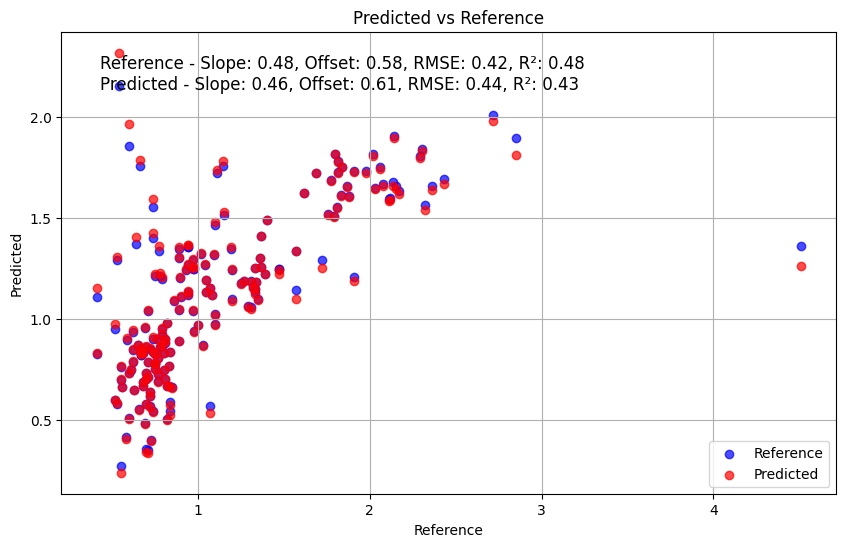

,Sample,Y_true,Y_opt,Y_pred
0,0,1.98,1.732467,1.726078
1,1,1.91,1.734958,1.730376
2,2,2.06,1.753046,1.745621
3,3,1.62,1.623114,1.623183
4,4,1.76,1.521420,1.517667
...,...,...,...,...
170,170,0.82,0.670527,0.667712
171,171,0.68,0.689826,0.690111
172,172,0.69,0.486158,0.478996
173,173,0.73,0.404572,0.394984


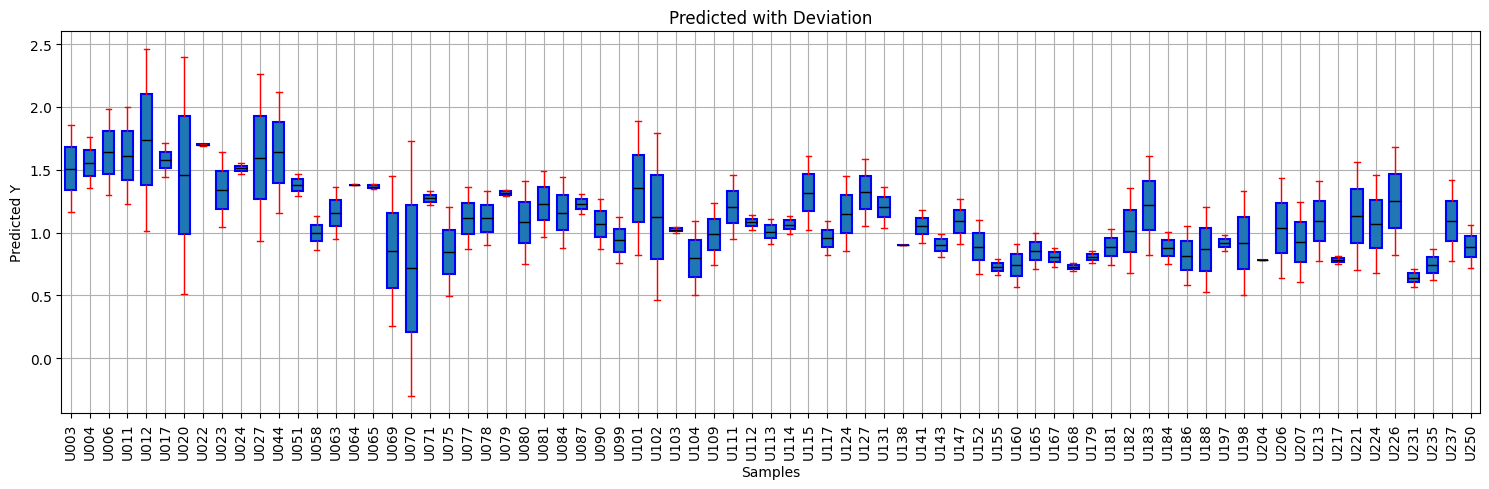

,Amostra,Y_pred,Y_true,Deviation
0,U003,1.509878,1.860,-0.350122
1,U004,1.555404,1.760,-0.204596
2,U006,1.637526,1.980,-0.342474
3,U011,1.612924,2.000,-0.387076
4,U012,1.738958,1.014,0.724958
...,...,...,...,...
70,U226,1.252180,0.820,0.432180
71,U231,0.640061,0.710,-0.069939
72,U235,0.744455,0.870,-0.125545
73,U237,1.093196,0.770,0.323196


In [7]:
calibration_msc_at, validation_msc_at, Y_predict_msc_at, plot_infos = build_model(df_msc_cal, df_msc_cal['AT'], df_msc_val, df_msc_val['AT'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'AT')


Número de componentes: 10


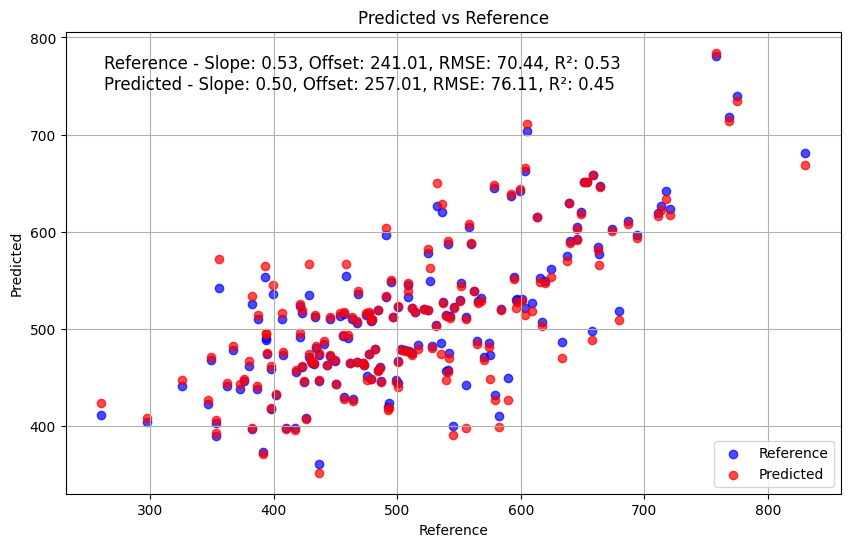

,Sample,Y_true,Y_opt,Y_pred
0,0,557.941,605.004015,607.594104
1,1,392.806,553.888034,565.153252
2,2,645.933,592.966277,591.019914
3,3,559.380,587.387896,588.385838
4,4,619.812,549.681773,547.582271
...,...,...,...,...
170,170,436.857,446.492687,446.944251
171,171,407.748,473.564931,476.402077
172,172,410.293,397.807266,396.991206
173,173,353.403,390.138786,392.993579


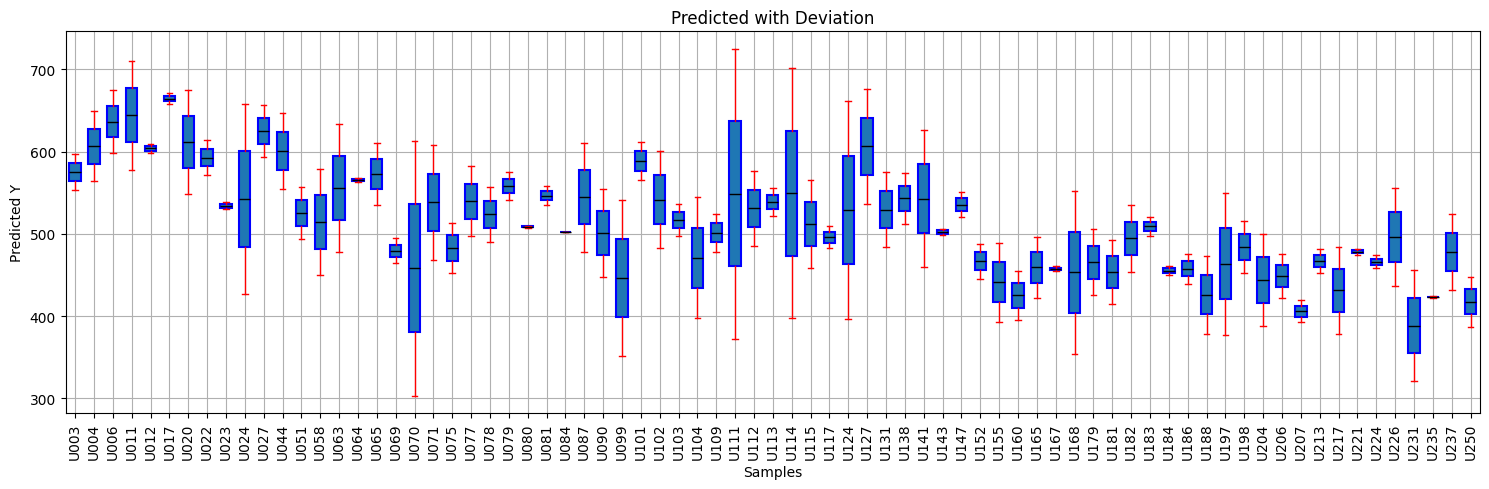

,Amostra,Y_pred,Y_true,Deviation
0,U003,575.631888,553.736,21.895888
1,U004,606.622551,564.029,42.593551
2,U006,636.503073,675.042,-38.538927
3,U011,643.961655,578.085,65.876655
4,U012,603.792915,598.008,5.784915
...,...,...,...,...
70,U226,496.279721,436.414,59.865721
71,U231,388.477045,455.451,-66.973955
72,U235,423.405131,424.239,-0.833869
73,U237,478.086325,524.627,-46.540675


In [8]:
calibration_msc_f, validation_msc_f, Y_predict_msc_f, plot_infos = build_model(df_msc_cal, df_msc_cal['FIRMEZA (N)'], df_msc_val, df_msc_val['FIRMEZA (N)'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'FIRMEZA (N)')


Número de componentes: 10


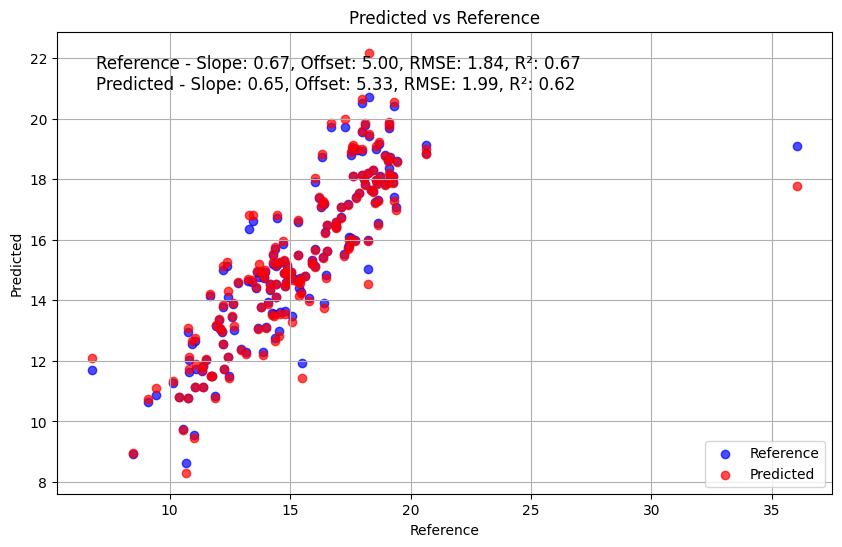

,Sample,Y_true,Y_opt,Y_pred
0,0,11.866295,10.846698,10.790585
1,1,12.206166,12.544263,12.567907
2,2,12.404207,12.128271,12.118131
3,3,14.014046,13.110014,13.077802
4,4,13.786897,13.791063,13.791188
...,...,...,...,...
170,170,16.703325,19.723741,19.865289
171,171,18.715851,18.110430,18.084332
172,172,18.260626,19.421920,19.497821
173,173,17.614441,19.029100,19.139036


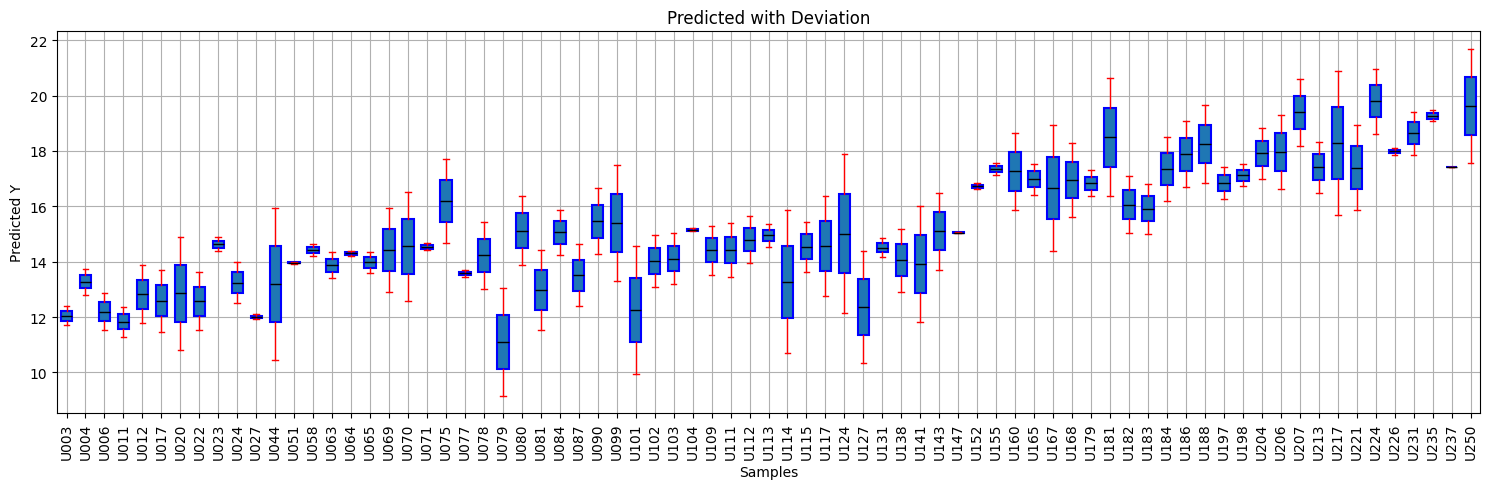

,Amostra,Y_pred,Y_true,Deviation
0,U003,12.048588,12.400951,-0.352363
1,U004,13.279732,12.813938,0.465794
2,U006,12.192779,12.867540,-0.674761
3,U011,11.828094,12.370821,-0.542727
4,U012,12.827192,11.784548,1.042643
...,...,...,...,...
70,U226,17.981779,17.858437,0.123341
71,U231,18.636233,17.851070,0.785163
72,U235,19.264050,19.461815,-0.197765
73,U237,17.408061,17.402479,0.005581


In [9]:
calibration_msc_f, validation_msc_f, Y_predict_msc_f, plot_infos = build_model(df_msc_cal, df_msc_cal['UBS (%)'], df_msc_val, df_msc_val['UBS (%)'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'UBS (%)')

In [10]:
plot_infos_msc.to_excel('plot_infos_pcr_msc.xlsx', index=False)
plot_infos_msc

,Attribute,Y,Slope,Offset,RMSE,R²
0,SST,Referência,0.762838,3.319183,1.293645,0.762838
1,SST,Predição,0.753293,3.462315,1.384473,0.728366
2,PH,Referência,0.419621,1.906267,0.234963,0.419621
3,PH,Predição,0.383215,2.025055,0.251125,0.337032
4,AT,Referência,0.479421,0.584495,0.423110,0.479421
5,AT,Predição,0.460509,0.605667,0.441383,0.433486
6,FIRMEZA (N),Referência,0.530197,241.013446,70.440768,0.530197
7,FIRMEZA (N),Predição,0.498513,257.014772,76.113094,0.451488
8,UBS (%),Referência,0.673939,5.001468,1.836867,0.673939
9,UBS (%),Predição,0.652690,5.334094,1.987495,0.618270


# SNV - PCR


Número de componentes: 4


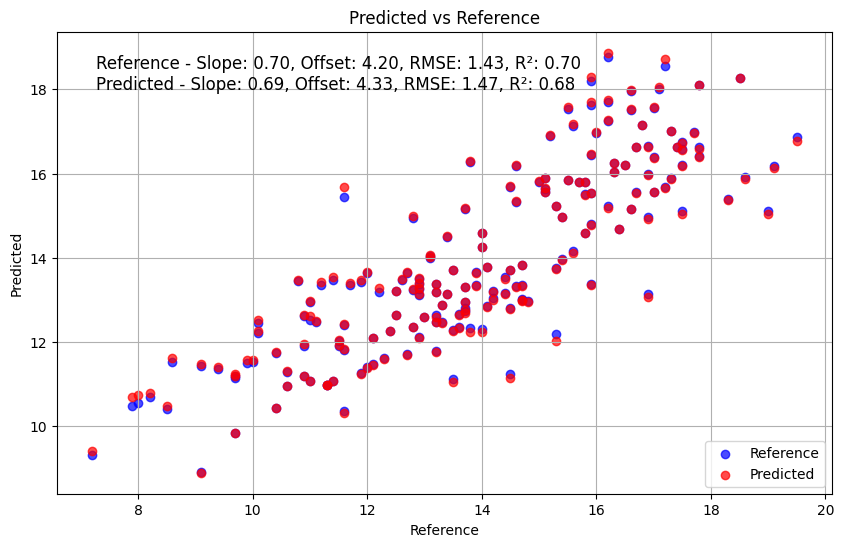

,Sample,Y_true,Y_opt,Y_pred
0,0,11.3,10.972533,10.963863
1,1,11.4,11.079877,11.073656
2,2,11.6,12.392429,12.427569
3,3,11.3,10.984033,10.976072
4,4,12.0,11.402068,11.379392
...,...,...,...,...
170,170,15.2,16.883146,16.918341
171,171,15.9,18.204646,18.285249
172,172,16.6,17.952629,17.990865
173,173,16.2,17.242039,17.272674


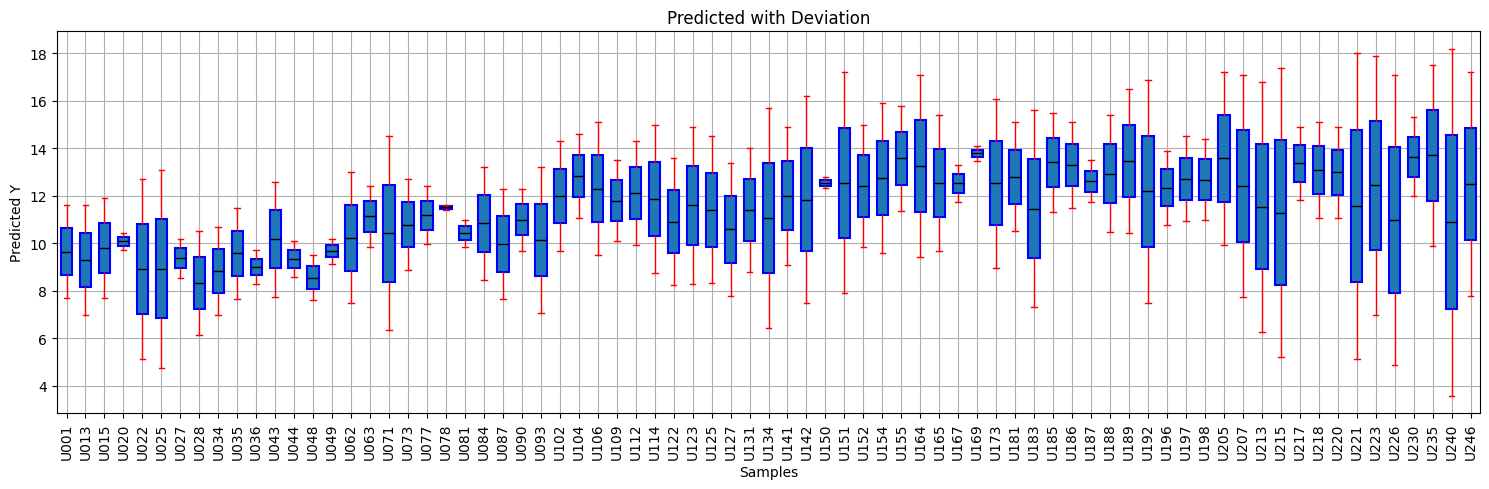

,Amostra,Y_pred,Y_true,Deviation
0,U001,9.649459,11.6,-1.950541
1,U013,9.294506,11.6,-2.305494
2,U015,9.798814,11.9,-2.101186
3,U020,10.075786,9.7,0.375786
4,U022,8.901861,12.7,-3.798139
...,...,...,...,...
70,U226,10.981079,17.1,-6.118921
71,U230,13.640150,15.3,-1.659850
72,U235,13.698848,17.5,-3.801152
73,U240,10.888983,18.2,-7.311017


In [11]:
calibration_snv_sst, validation_snv_sst, Y_predict_snv_sst, plot_infos = build_model(df_snv_cal, df_snv_cal['SST'], df_snv_val, df_snv_val['SST'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'SST')

Número de componentes: 10


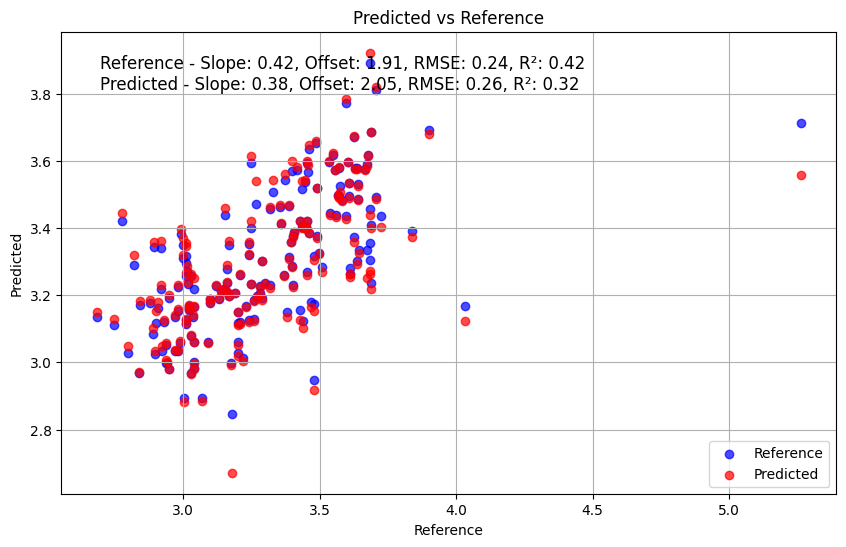

,Sample,Y_true,Y_opt,Y_pred
0,0,3.49,3.376463,3.369310
1,1,3.56,3.439165,3.433455
2,2,3.57,3.495372,3.488095
3,3,3.57,3.579711,3.580062
4,4,3.55,3.618510,3.624155
...,...,...,...,...
170,170,3.13,3.188567,3.191199
171,171,3.20,3.060892,3.052112
172,172,3.21,3.120100,3.112840
173,173,3.20,3.150990,3.149173


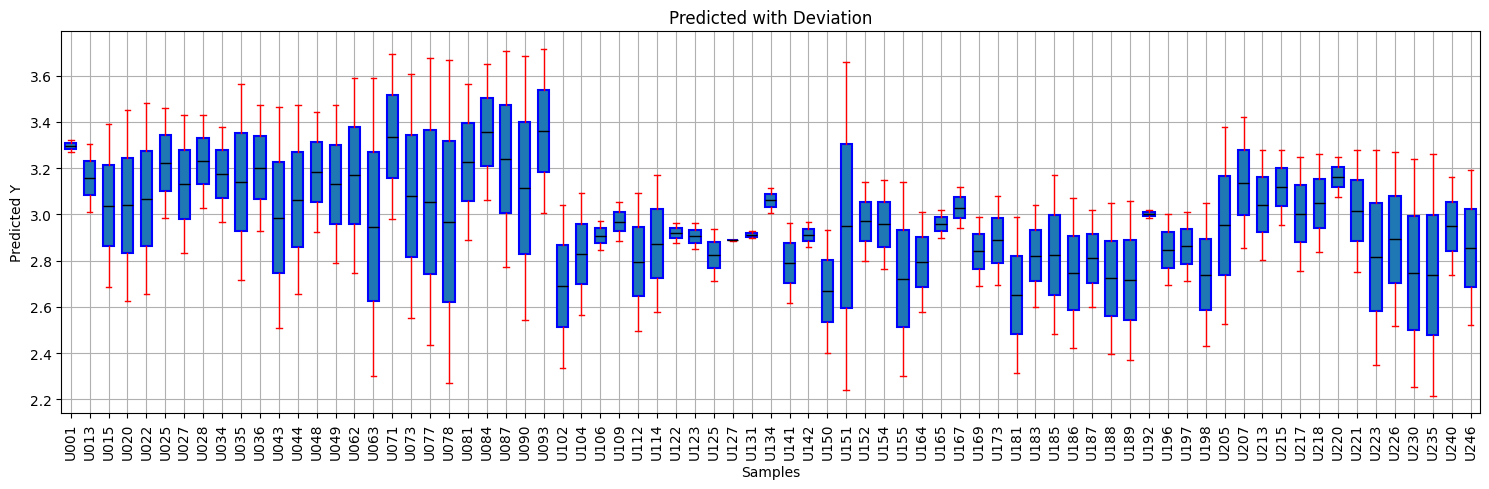

,Amostra,Y_pred,Y_true,Deviation
0,U001,3.296509,3.270,0.026509
1,U013,3.157370,3.306,-0.148630
2,U015,3.037639,3.390,-0.352361
3,U020,3.038505,3.450,-0.411495
4,U022,3.068393,3.482,-0.413607
...,...,...,...,...
70,U226,2.892864,3.270,-0.377136
71,U230,2.745575,3.240,-0.494425
72,U235,2.737865,3.260,-0.522135
73,U240,2.948372,3.160,-0.211628


In [12]:
calibration_snv_ph, validation_snv_ph, Y_predict_snv_ph, plot_infos = build_model(df_snv_cal, df_snv_cal['PH'], df_snv_val, df_snv_val['PH'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'PH')

Número de componentes: 5


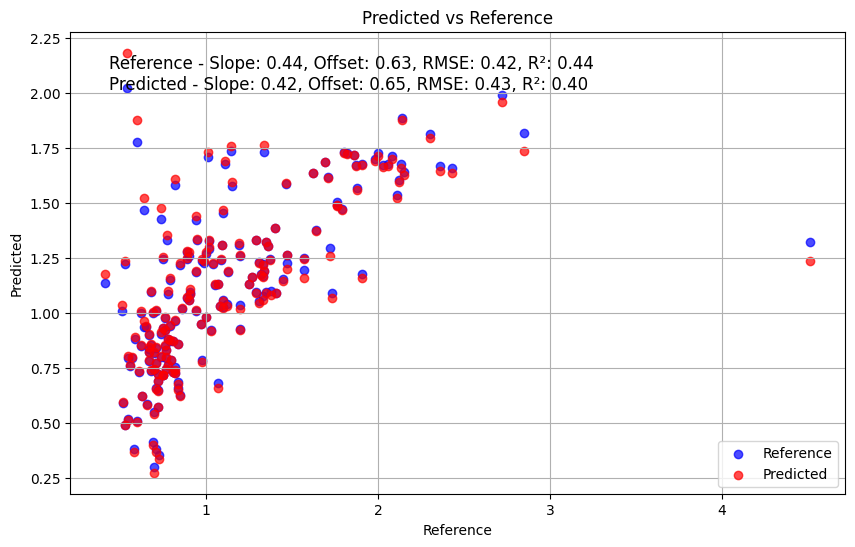

,Sample,Y_true,Y_opt,Y_pred
0,0,1.91,1.676141,1.669902
1,1,1.86,1.719696,1.715993
2,2,1.76,1.503840,1.492389
3,3,2.06,1.678851,1.668717
4,4,1.98,1.700607,1.689582
...,...,...,...,...
170,170,0.82,0.727970,0.725692
171,171,0.69,0.412580,0.398631
172,172,0.73,0.354431,0.335608
173,173,0.63,0.622189,0.621941


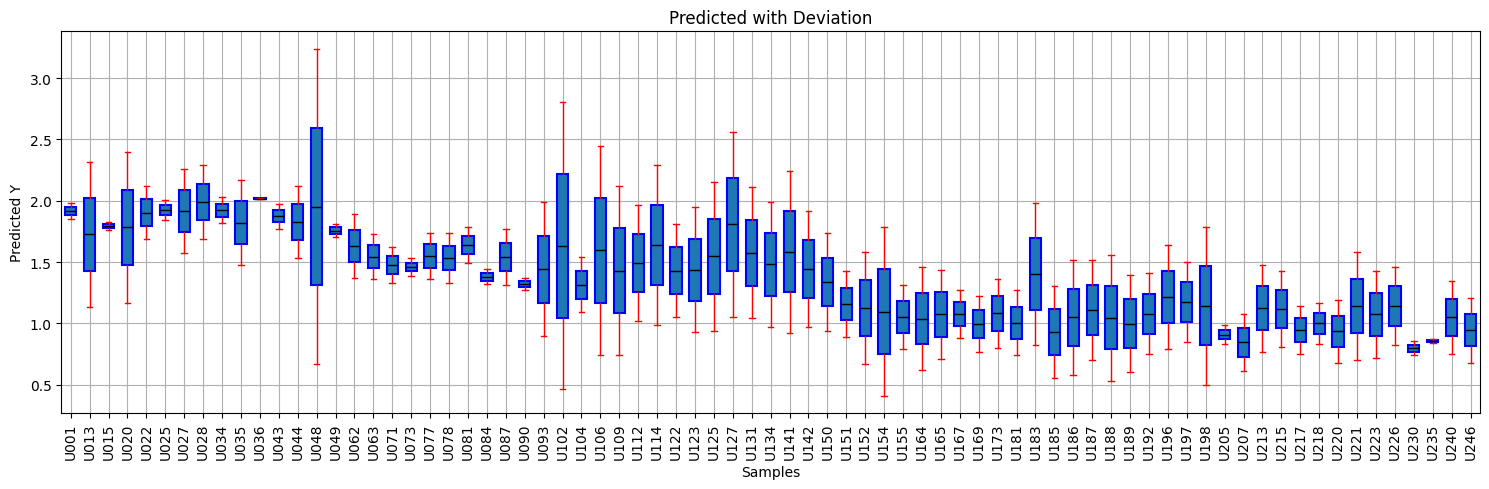

,Amostra,Y_pred,Y_true,Deviation
0,U001,1.916458,1.98,-0.063542
1,U013,1.726885,2.32,-0.593115
2,U015,1.795247,1.83,-0.034753
3,U020,1.781916,2.40,-0.618084
4,U022,1.903845,1.69,0.213845
...,...,...,...,...
70,U226,1.141548,0.82,0.321548
71,U230,0.795997,0.74,0.055997
72,U235,0.856691,0.87,-0.013309
73,U240,1.048835,0.75,0.298835


In [13]:
calibration_snv_at, validation_snv_at, Y_predict_snv_at, plot_infos = build_model(df_snv_cal, df_snv_cal['AT'], df_snv_val, df_snv_val['AT'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'AT')

Número de componentes: 8


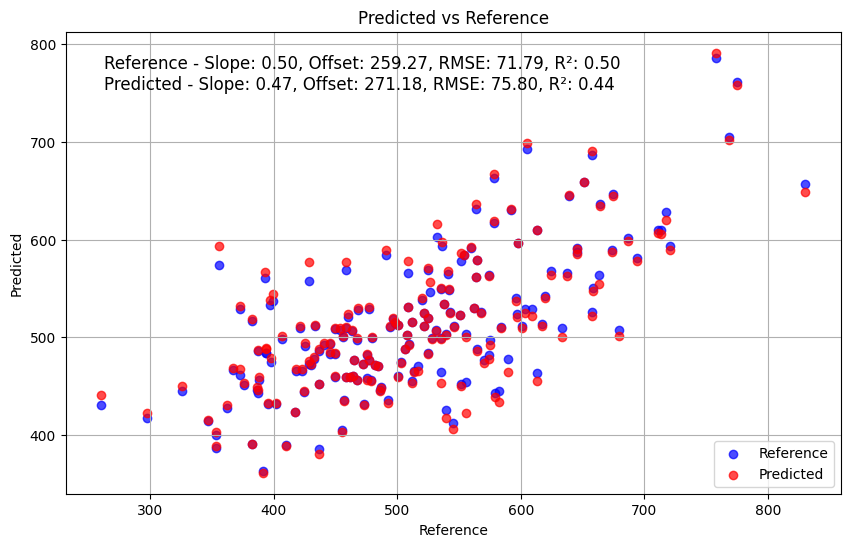

,Sample,Y_true,Y_opt,Y_pred
0,0,392.806,560.293978,567.284177
1,1,553.736,583.741583,584.752862
2,2,564.029,631.031783,636.653996
3,3,645.933,591.754368,589.879541
4,4,675.042,646.421155,644.833950
...,...,...,...,...
170,170,436.857,451.812389,452.323283
171,171,410.293,389.789526,388.527984
172,172,353.403,386.677403,388.649013
173,173,401.771,431.706267,432.806658


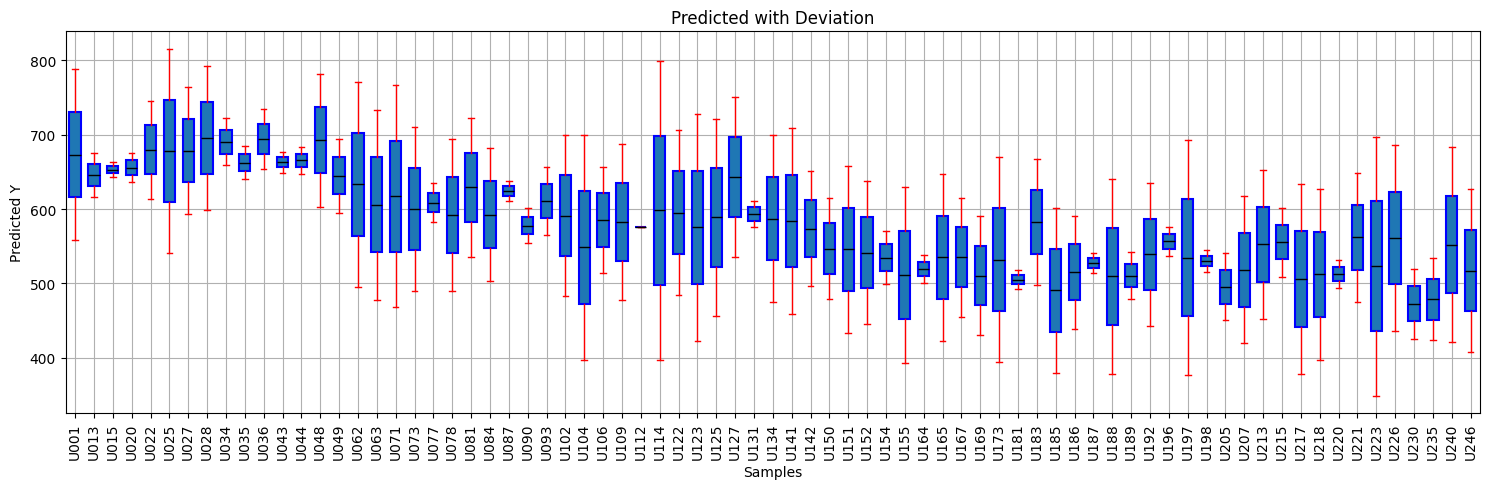

,Amostra,Y_pred,Y_true,Deviation
0,U001,673.043245,557.941,115.102245
1,U013,645.569159,615.938,29.631159
2,U015,652.981554,662.756,-9.774446
3,U020,655.544592,675.152,-19.607408
4,U022,679.401455,613.835,65.566455
...,...,...,...,...
70,U226,561.089104,436.414,124.675104
71,U230,472.913850,425.789,47.124850
72,U235,478.987515,424.239,54.748515
73,U240,552.004462,421.140,130.864462


In [14]:
calibration_snv_f, validation_snv_f, Y_predict_snv_f, plot_infos = build_model(df_snv_cal, df_snv_cal['FIRMEZA (N)'], df_snv_val, df_snv_val['FIRMEZA (N)'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'FIRMEZA (N)')

Número de componentes: 4


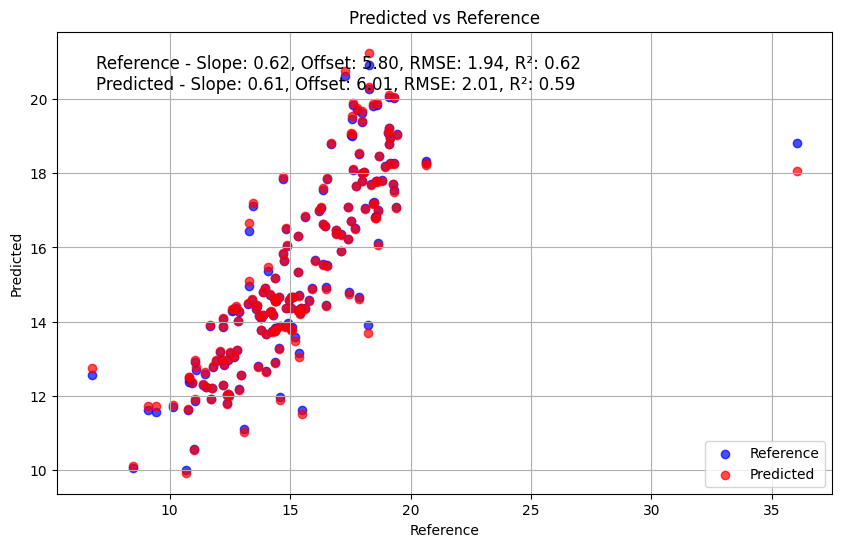

,Sample,Y_true,Y_opt,Y_pred
0,0,12.206166,12.299360,12.301827
1,1,12.400951,12.025783,12.018492
2,2,12.813938,13.228455,13.246837
3,3,12.404207,12.065461,12.056925
4,4,12.867540,12.192357,12.166752
...,...,...,...,...
170,170,16.703325,18.774421,18.817729
171,171,18.260626,20.253824,20.323534
172,172,17.614441,19.832632,19.895337
173,173,17.966201,19.367758,19.408963


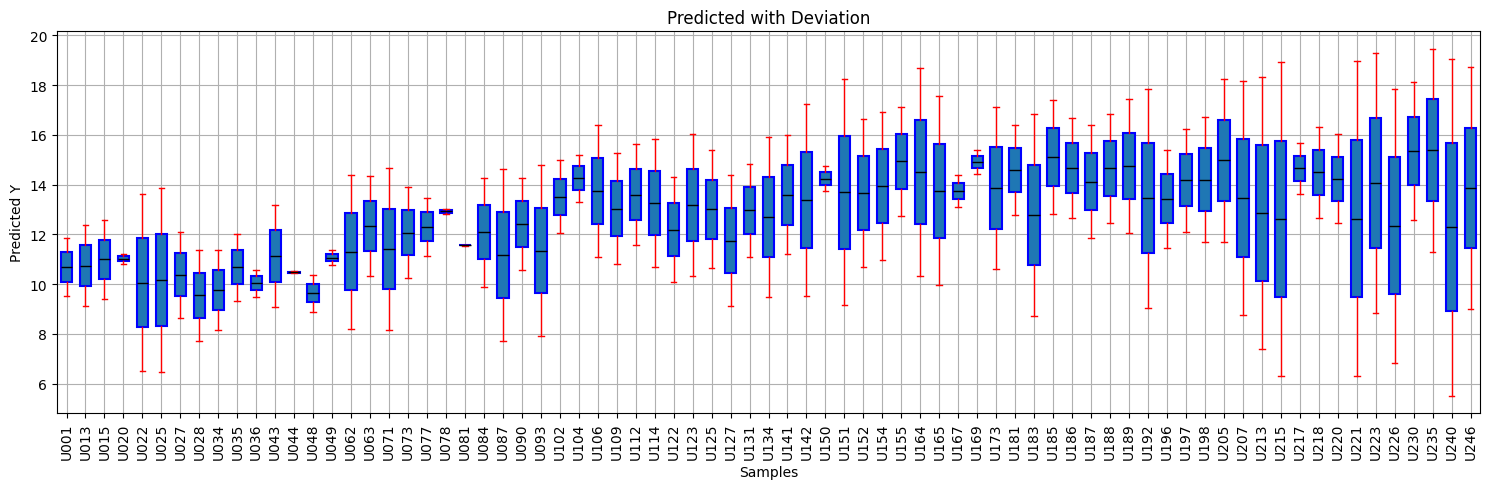

,Amostra,Y_pred,Y_true,Deviation
0,U001,10.687278,11.866295,-1.179017
1,U013,10.739960,12.376837,-1.636876
2,U015,10.994884,12.583001,-1.588118
3,U020,11.016788,10.825132,0.191655
4,U022,10.060771,13.621190,-3.560419
...,...,...,...,...
70,U226,12.351399,17.858437,-5.507039
71,U230,15.347975,18.106641,-2.758666
72,U235,15.385039,19.461815,-4.076776
73,U240,12.290783,19.066069,-6.775286


In [15]:
calibration_snv_ubs, validation_snv_ubs, Y_predict_snv_ubs, plot_infos = build_model(df_snv_cal, df_snv_cal['UBS (%)'], df_snv_val, df_snv_val['UBS (%)'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'UBS (%)')

In [16]:
plot_infos_snv.to_excel('plot_infos_pcr_snv.xlsx', index=False)
plot_infos_snv

,Attribute,Y,Slope,Offset,RMSE,R²
0,SST,Referência,0.698320,4.198865,1.429581,0.698320
1,SST,Predição,0.689607,4.325758,1.472501,0.679934
2,PH,Referência,0.420069,1.914546,0.238466,0.420069
3,PH,Predição,0.379565,2.047328,0.257604,0.323249
4,AT,Referência,0.444342,0.625341,0.416825,0.444342
5,AT,Predição,0.423843,0.648776,0.434809,0.395360
6,FIRMEZA (N),Referência,0.495716,259.267418,71.786873,0.495716
7,FIRMEZA (N),Predição,0.472604,271.175375,75.803353,0.437708
8,UBS (%),Referência,0.620437,5.798143,1.938561,0.620437
9,UBS (%),Predição,0.606768,6.010206,2.012278,0.591021


# SG - PCR

Número de componentes: 6


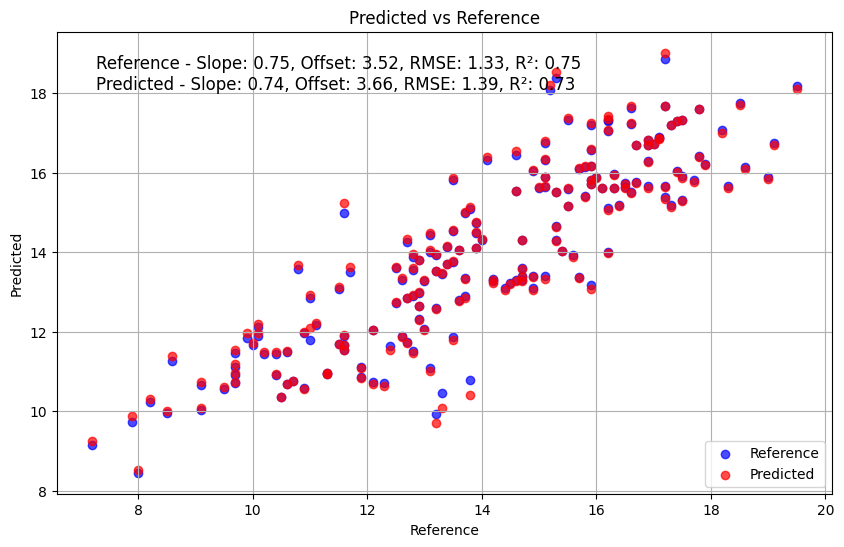

,Sample,Y_true,Y_opt,Y_pred
0,0,11.6,11.661505,11.663211
1,1,11.3,10.939347,10.928502
2,2,11.3,10.974026,10.966511
3,3,12.7,11.754026,11.729064
4,4,12.8,11.508526,11.460289
...,...,...,...,...
170,170,15.2,18.071600,18.214733
171,171,17.2,15.678494,15.632485
172,172,15.9,16.569359,16.601287
173,173,16.6,17.624364,17.682595


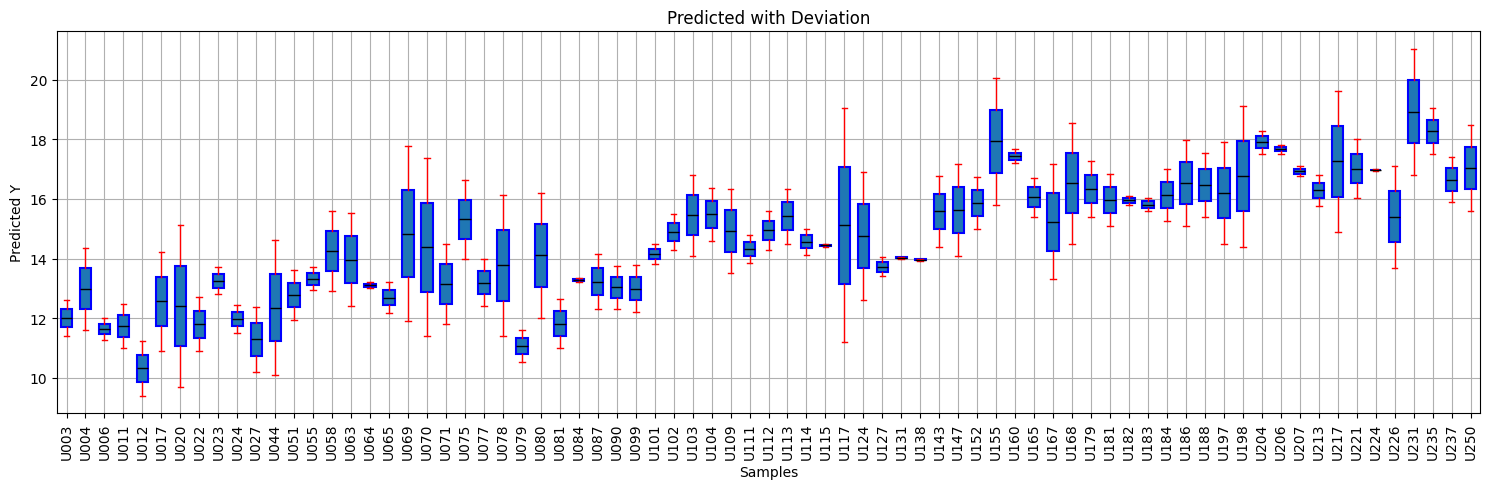

,Amostra,Y_pred,Y_true,Deviation
0,U003,12.000167,11.4,0.600167
1,U004,12.982120,11.6,1.382120
2,U006,11.634495,12.0,-0.365505
3,U011,11.736793,11.0,0.736793
4,U012,10.311254,9.4,0.911254
...,...,...,...,...
70,U226,15.396419,17.1,-1.703581
71,U231,18.919487,16.8,2.119487
72,U235,18.270912,17.5,0.770912
73,U237,16.650249,15.9,0.750249


In [17]:
calibration_sg_sst, validation_sg_sst, Y_predict_sg_sst, plot_infos = build_model(df_sg_cal, df_sg_cal['SST'], df_sg_val, df_sg_val['SST'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'SST')

Número de componentes: 9


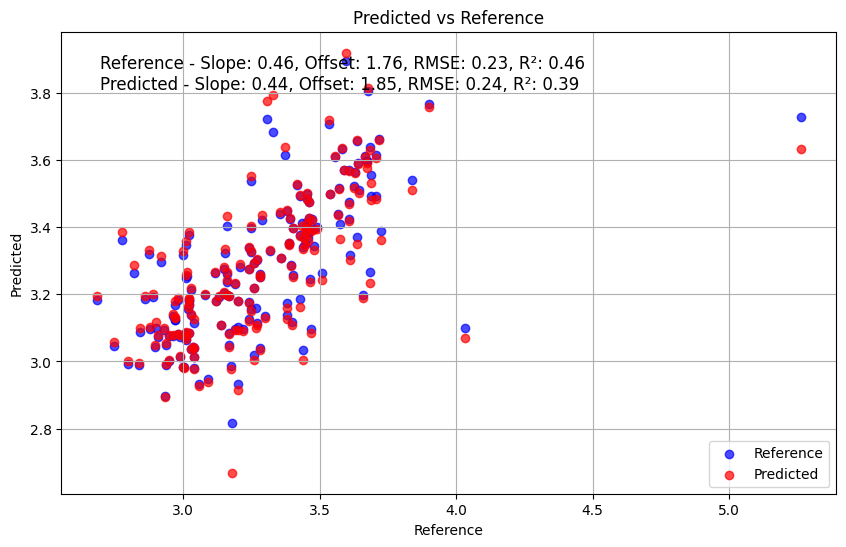

,Sample,Y_true,Y_opt,Y_pred
0,0,3.270,3.303995,3.304989
1,1,3.490,3.401608,3.395915
2,2,3.570,3.516536,3.514989
3,3,3.607,3.474606,3.470891
4,4,3.643,3.512103,3.502972
...,...,...,...,...
170,170,3.130,3.191793,3.195464
171,171,3.190,3.095985,3.092870
172,172,3.200,3.103307,3.095105
173,173,3.210,3.280956,3.289949


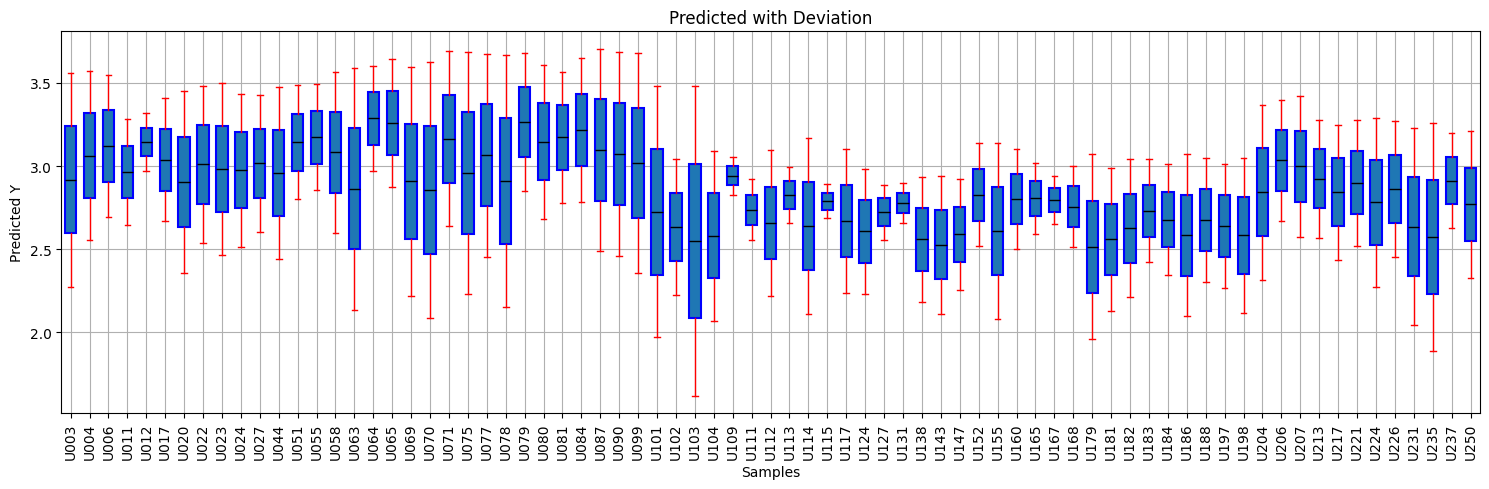

,Amostra,Y_pred,Y_true,Deviation
0,U003,2.916579,3.560,-0.643421
1,U004,3.063242,3.570,-0.506758
2,U006,3.121457,3.550,-0.428543
3,U011,2.964668,3.282,-0.317332
4,U012,3.144958,3.318,-0.173042
...,...,...,...,...
70,U226,2.862392,3.270,-0.407608
71,U231,2.636602,3.230,-0.593398
72,U235,2.574568,3.260,-0.685432
73,U237,2.913439,3.200,-0.286561


In [18]:
calibration_sg_ph, validation_sg_ph, Y_predict_sg_ph, plot_infos = build_model(df_sg_cal, df_sg_cal['PH'], df_sg_val, df_sg_val['PH'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'PH')

Número de componentes: 10


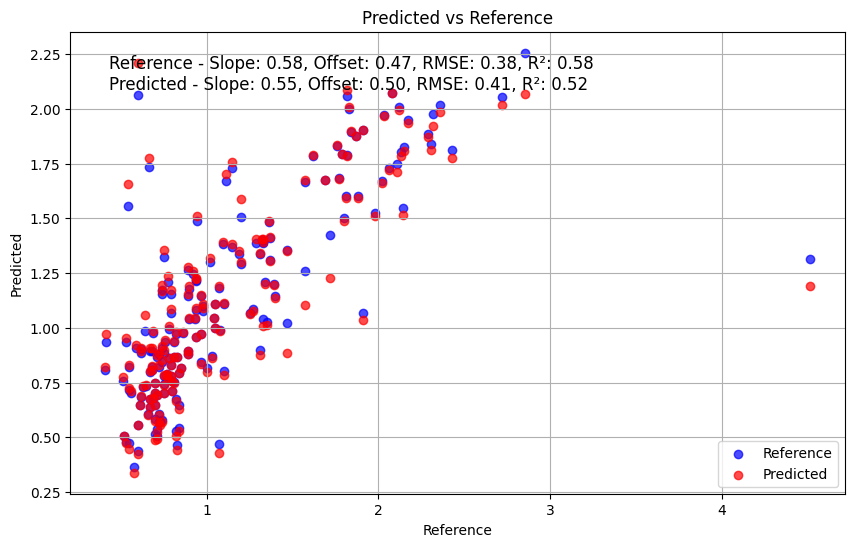

,Sample,Y_true,Y_opt,Y_pred
0,0,1.98,1.526187,1.510374
1,1,1.91,1.903548,1.903122
2,2,2.06,1.730149,1.719991
3,3,1.62,1.785264,1.790764
4,4,1.76,1.827822,1.833404
...,...,...,...,...
170,170,0.82,0.673629,0.664928
171,171,0.68,0.823179,0.828013
172,172,0.69,0.680807,0.680024
173,173,0.73,0.575384,0.554679


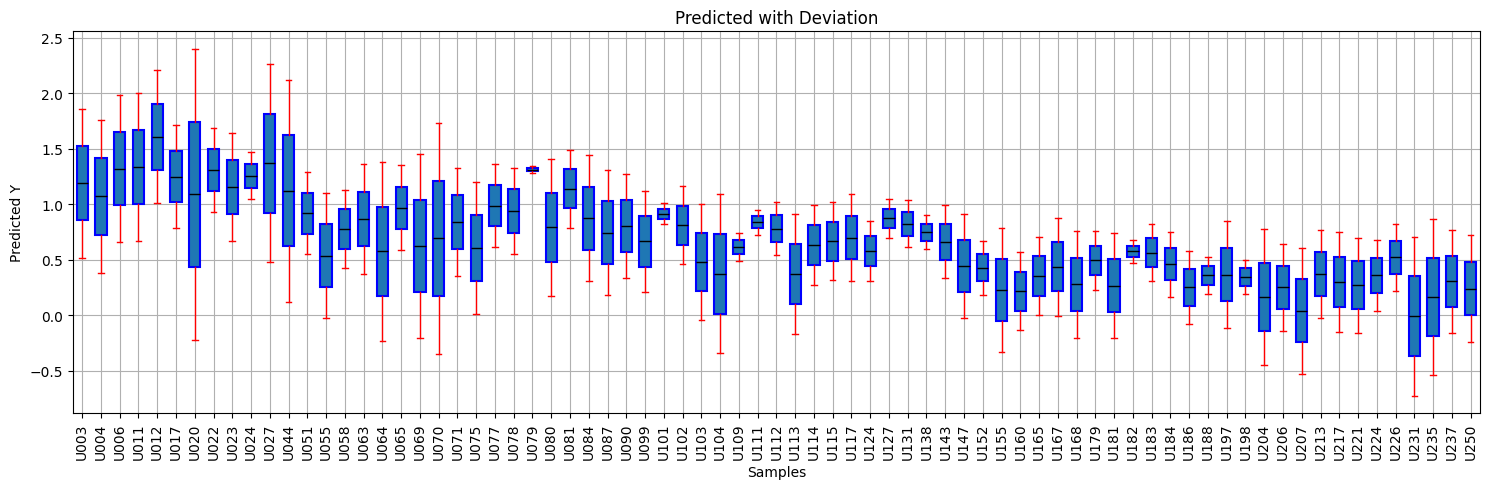

,Amostra,Y_pred,Y_true,Deviation
0,U003,1.190258,1.860,-0.669742
1,U004,1.071639,1.760,-0.688361
2,U006,1.319729,1.980,-0.660271
3,U011,1.333901,2.000,-0.666099
4,U012,1.608940,1.014,0.594940
...,...,...,...,...
70,U226,0.521719,0.820,-0.298281
71,U231,-0.005784,0.710,-0.715784
72,U235,0.168599,0.870,-0.701401
73,U237,0.306940,0.770,-0.463060


In [19]:
calibration_sg_at, validation_sg_at, Y_predict_sg_at, plot_infos = build_model(df_sg_cal, df_sg_cal['AT'], df_sg_val, df_sg_val['AT'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'AT')

Número de componentes: 8


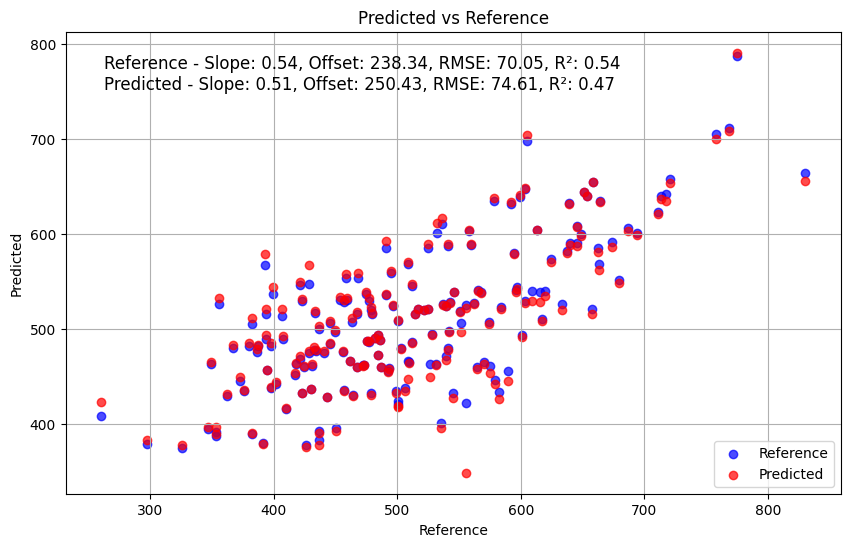

,Sample,Y_true,Y_opt,Y_pred
0,0,557.941,602.883234,604.151975
1,1,392.806,567.839727,578.899902
2,2,645.933,608.503548,607.460793
3,3,559.380,588.737309,589.544469
4,4,619.812,540.068503,534.511553
...,...,...,...,...
170,170,436.857,393.213561,390.931704
171,171,407.748,489.513461,492.200431
172,172,410.293,416.346225,416.858448
173,173,353.403,391.732494,396.536759


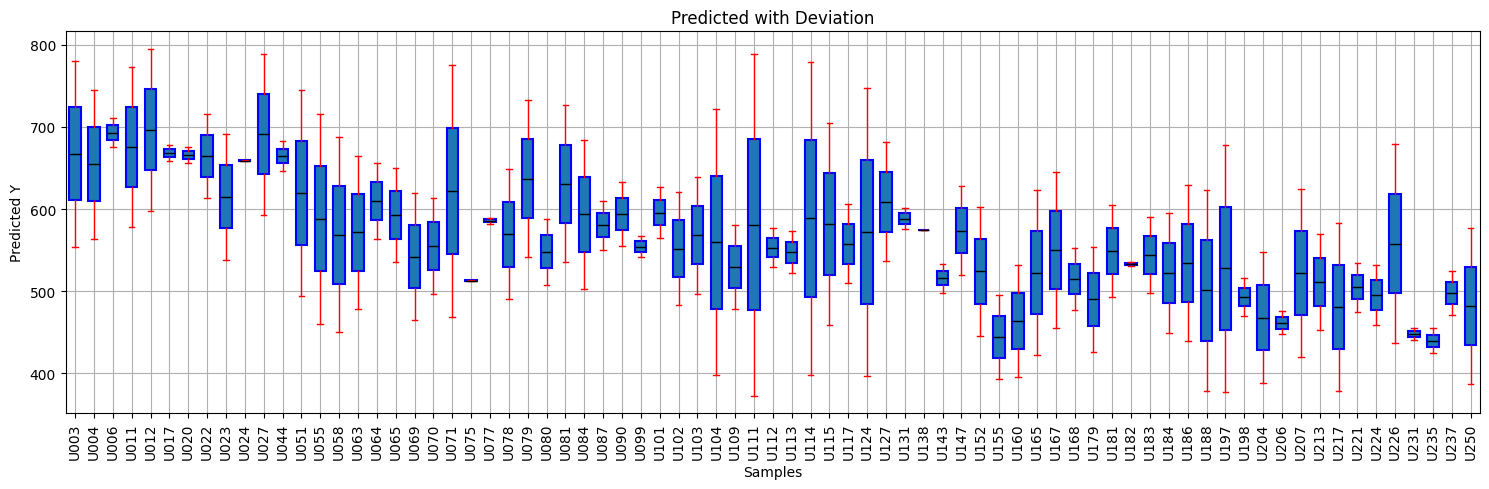

,Amostra,Y_pred,Y_true,Deviation
0,U003,667.194789,553.736,113.458789
1,U004,654.697937,564.029,90.668937
2,U006,693.038949,675.042,17.996949
3,U011,675.566441,578.085,97.481441
4,U012,696.709651,598.008,98.701651
...,...,...,...,...
70,U226,557.944370,436.414,121.530370
71,U231,448.215166,455.451,-7.235834
72,U235,439.361802,424.239,15.122802
73,U237,498.041661,524.627,-26.585339


In [20]:
calibration_sg_f, validation_sg_f, Y_predict_sg_f, plot_infos = build_model(df_sg_cal, df_sg_cal['FIRMEZA (N)'], df_sg_val, df_sg_val['FIRMEZA (N)'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'FIRMEZA (N)')

Número de componentes: 7


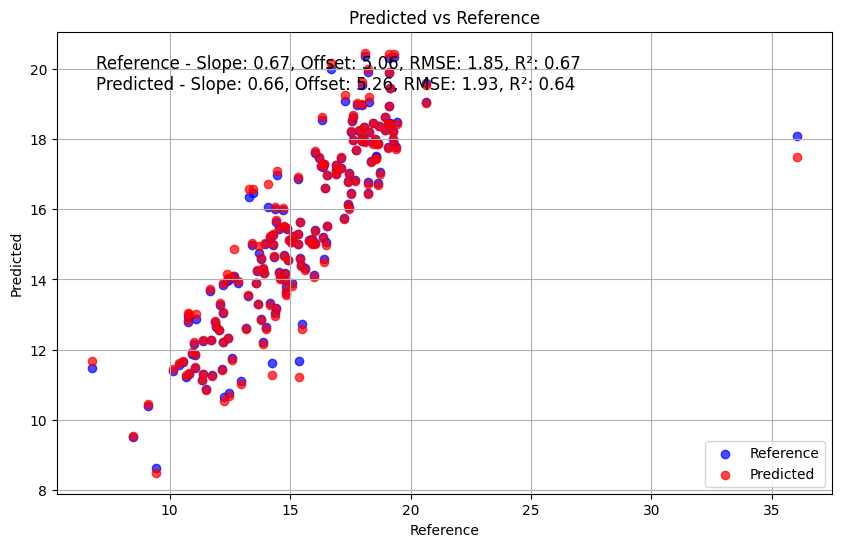

,Sample,Y_true,Y_opt,Y_pred
0,0,11.866295,12.797297,12.823552
1,1,12.206166,12.222999,12.223509
2,2,12.404207,12.340835,12.339125
3,3,14.014046,12.636477,12.600122
4,4,13.786897,12.881527,12.847211
...,...,...,...,...
170,170,16.703325,20.000794,20.170515
171,171,18.715851,17.064304,17.011662
172,172,18.260626,18.214195,18.211917
173,173,17.614441,18.619423,18.694392


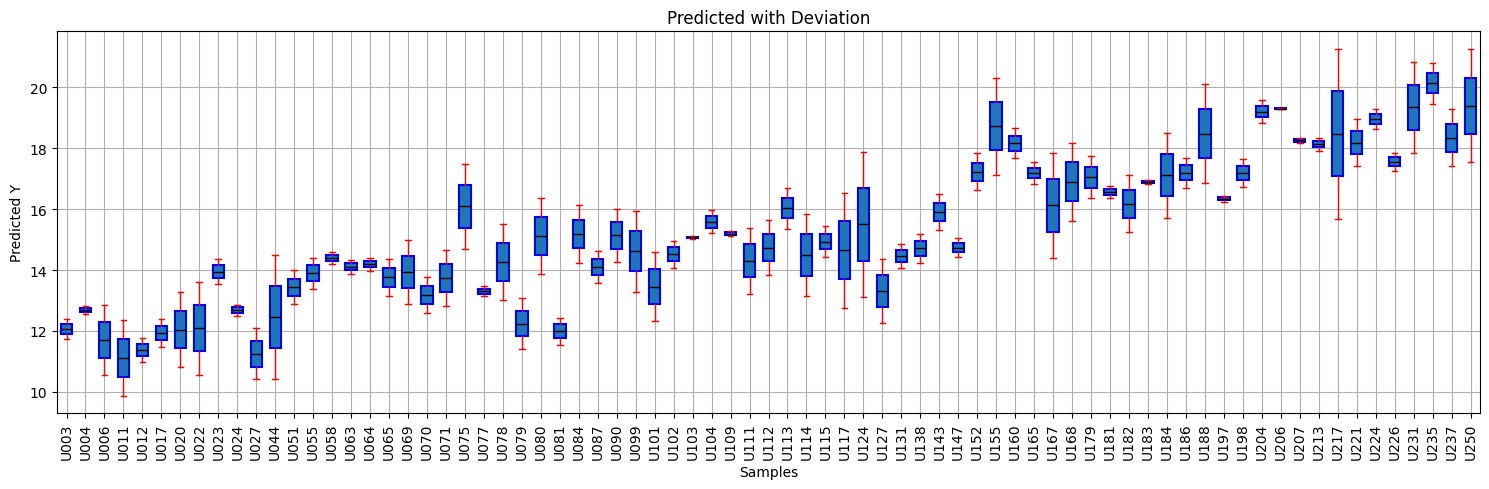

,Amostra,Y_pred,Y_true,Deviation
0,U003,12.071760,12.400951,-0.329191
1,U004,12.691616,12.813938,-0.122322
2,U006,11.706258,12.867540,-1.161282
3,U011,11.124215,12.370821,-1.246605
4,U012,11.388974,11.784548,-0.395575
...,...,...,...,...
70,U226,17.555403,17.858437,-0.303034
71,U231,19.338657,17.851070,1.487587
72,U235,20.136681,19.461815,0.674866
73,U237,18.340433,17.402479,0.937954


In [21]:
calibration_sg_ubs, validation_sg_ubs, Y_predict_sg_ubs, plot_infos = build_model(df_sg_cal, df_sg_cal['UBS (%)'], df_sg_val, df_sg_val['UBS (%)'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'UBS (%)')

In [22]:
plot_infos_sg.to_excel('plot_infos_pcr_sg.xlsx', index=False)
plot_infos_sg

,Attribute,Y,Slope,Offset,RMSE,R²
0,SST,Referência,0.748424,3.522633,1.332766,0.748424
1,SST,Predição,0.738951,3.660697,1.391742,0.725667
2,PH,Referência,0.463545,1.760382,0.226293,0.463545
3,PH,Predição,0.436002,1.849356,0.241059,0.391252
4,AT,Referência,0.577300,0.474163,0.381392,0.577300
5,AT,Predição,0.548804,0.503335,0.406589,0.519604
6,FIRMEZA (N),Referência,0.535407,238.339206,70.050211,0.535407
7,FIRMEZA (N),Predição,0.510798,250.425425,74.606076,0.473011
8,UBS (%),Referência,0.670178,5.062153,1.847196,0.670178
9,UBS (%),Predição,0.657998,5.258985,1.932624,0.638965
